# Evaluation Results

In [4]:
import os
from pathlib import Path
from semconstmining.config import Config
import warnings
warnings.filterwarnings('ignore')
res_file = "BL_all_2023-07-20 11-28-16.csv"
conf = Config(Path(os.getcwd()).parents[1].resolve(), "sap_sam_filtered")

import pandas as pd
import matplotlib.pyplot as plt

run_results_df = pd.read_csv(conf.DATA_EVAL / res_file)
if "fold" not in run_results_df.columns:
    run_results_df["fold"] = 0
if "config" not in run_results_df.columns:
    run_results_df["config"] = "best"
if "run_time" not in run_results_df.columns:
    run_results_df["run_time"] = 0
run_results_df

,log_name,support,precision,recall,f1,tp,fp,fn,fold,config,run_time
0,306d109a702341bdb9eb7669c0ebb08b,0.0,1.0,0.000000,0.00000,0.0,0.0,5.0,0,best,0
1,5285aa4838b1472583e0a0c947e7fab9,0.0,1.0,0.000000,0.00000,0.0,0.0,20.0,0,best,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,best,0
3,37643f2a47c347d88b768c4f20ec6232,0.0,1.0,0.000000,0.00000,0.0,0.0,5.0,0,best,0
4,fed9fc3887304b6dbe66f62038608f1a,98.0,1.0,0.507772,0.67354,98.0,0.0,95.0,0,best,0
...,...,...,...,...,...,...,...,...,...,...,...
1341,167fb016c79d4f19847bf14646d1313f,0.0,1.0,0.000000,0.00000,0.0,0.0,82.0,4,best,0
1342,56884b398eba4fb5a38b9d212e7637bd,4.0,0.0,0.000000,0.00000,0.0,4.0,40.0,4,best,0
1343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,best,0
1344,37821011de084b7a95dd70882696f7be,0.0,1.0,0.000000,0.00000,0.0,0.0,83.0,4,best,0


In [41]:
import time
fold_dfs = []
const_types = [conf.ACTIVITY, conf.RESOURCE, conf.OBJECT, conf.MULTI_OBJECT]
for fold_num, fold_df in run_results_df.groupby("fold"):
    avg_frames = []
    for config, group in fold_df.groupby("config"):
        config_results = {}
        avg_precision = group.loc[group["support"] > 0, "precision"].mean()
        avg_recall = group.loc[group["support"] > 0, "recall"].mean()
        #avg_f1 = group.loc[group["support"] > 0, "f1"].mean()
        avg_support = group.loc[group["support"] > 0, "support"].mean()
        total_support = group["support"].sum()
        avg_run_time = group["run_time"].mean()
        tp_avg = group["tp"].mean()
        fp_avg = group["fp"].mean()
        fn_avg = group["fn"].mean()
        tp_total = group["tp"].sum()
        fp_total = group["fp"].sum()
        fn_total = group["fn"].sum()
        config_results["config"] = config
        config_results["avg_precision"] = avg_precision
        config_results["avg_recall"] = avg_recall
        #config_results["avg_f1"] = avg_f1
        config_results["avg_support"] = avg_support
        config_results["total_support"] = total_support
        config_results["avg_run_time"] = avg_run_time
        config_results["tp_avg"] = tp_avg
        config_results["fp_avg"] = fp_avg
        config_results["fn_avg"] = fn_avg
        config_results["tp_total"] = tp_total
        config_results["fp_total"] = fp_total
        config_results["fn_total"] = fn_total
        if "BL" in res_file:
            avg_frames.append(config_results)
            continue
        per_const_dict = {}
        for const_type in const_types:
            const_type_avg_precision = group.loc[group[f"{const_type}_support"] > 0, f"{const_type}_precision"].mean()
            const_type_avg_recall = group.loc[group[f"{const_type}_support"] > 0, f"{const_type}_recall"].mean()
            #const_type_avg_f1 = group.loc[group[f"{const_type}_support"] > 0, f"{const_type}_f1"].mean()
            const_type_avg_support = group.loc[group[f"{const_type}_support"] > 0, f"{const_type}_support"].mean()
            const_type_total_support = group[f"{const_type}_support"].sum()
            const_tp_avg = group[f"{const_type}_tp"].mean()
            const_fp_avg = group[f"{const_type}_fp"].mean()
            const_fn_avg = group[f"{const_type}_fn"].mean()
            # const_tp_total = group[f"{const_type}_tp"].sum()
            # const_fp_total = group[f"{const_type}_fp"].sum()
            # const_fn_total = group[f"{const_type}_fn"].sum()
            per_const_dict |= {
                f"{const_type}_precision": const_type_avg_precision,
                f"{const_type}_recall": const_type_avg_recall,
                #f"{const_type}_f1": const_type_avg_f1,
                f"{const_type}_support": const_type_avg_support,
                f"{const_type}_total_support": const_type_total_support,
                f"{const_type}_tp": const_tp_avg,
                f"{const_type}_fp": const_fp_avg,
                f"{const_type}_fn": const_fn_avg,
                # f"{const_type}_total_tp": const_tp_total,
                # f"{const_type}_total_fp": const_fp_total,
                # f"{const_type}_total_fn": const_fn_total,
            }
        config_results|= per_const_dict
        avg_frames.append(config_results)
    avg_results_df = pd.DataFrame.from_records(avg_frames)
    avg_results_df.to_csv(conf.DATA_EVAL / f"average_{time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime())}-{fold_num}.csv",
                            index=False)
    fold_dfs.append(avg_results_df)
average_df = pd.concat(fold_dfs, ignore_index=True)

In [5]:
const_column = []
k_column = []
omega_column = []
tau_column = []
support_column = []
tp_column = []
fp_column = []
fn_column = []
prec_column = []
rec_column = []
if "BL" in res_file:
    const_type_avg_precision = run_results_df[f"precision"].mean()
    const_type_avg_recall = run_results_df[f"recall"].mean()
    #const_type_avg_f1 = average_df[f"precision"].mean()
    const_type_avg_support = run_results_df[f"support"].mean()
    const_tp_avg = run_results_df[f"tp"].mean()
    const_fp_avg = run_results_df[f"fp"].mean()
    const_fn_avg = run_results_df[f"fn"].mean()

    const_column.append("Object")
    k_column.append("")
    omega_column.append("")
    tau_column.append("")
    support_column.append(const_type_avg_support)
    tp_column.append(const_tp_avg)
    fp_column.append(const_fp_avg)
    fn_column.append(const_fn_avg)
    prec_column.append(const_type_avg_precision)
    rec_column.append(const_type_avg_recall)
else:
    for const_type in const_types:
        for config, group in run_results_df.groupby("config"):
            k = config.split("-")[2]
            omega = config.split("-")[1]
            tau = config.split("-")[0]
            const_type_avg_precision = group.loc[group[f"{const_type}_support"] > 0, f"{const_type}_precision"].mean()
            const_type_avg_recall = group.loc[group[f"{const_type}_support"] > 0, f"{const_type}_recall"].mean()
            #const_type_avg_f1 = group.loc[group[f"{const_type}_support"] > 0, f"{const_type}_f1"].mean()
            const_type_avg_support = group.loc[group[f"{const_type}_support"] > 0, f"{const_type}_support"].mean()
            const_tp_avg = group[f"{const_type}_tp"].mean()
            const_fp_avg = group[f"{const_type}_fp"].mean()
            const_fn_avg = group[f"{const_type}_fn"].mean()


            const_column.append(const_type)
            k_column.append(k)
            omega_column.append(omega)
            tau_column.append(tau)
            support_column.append(const_type_avg_support)
            tp_column.append(const_tp_avg)
            fp_column.append(const_fp_avg)
            fn_column.append(const_fn_avg)
            prec_column.append(const_type_avg_precision)
            rec_column.append(const_type_avg_recall)

In [6]:
table_df = pd.DataFrame({
    'Type': const_column,
    'k': k_column,
    '$\omega$': omega_column,
    '$\tau$': tau_column,
    #"Support": support_column,
    'TP': tp_column,
    'FP': fp_column,
    'FN': fn_column,
    'Precision': prec_column,
    'Recall': rec_column
})
table_df

,Type,k,$\omega$,$\tau$,TP,FP,FN,Precision,Recall
0,Object,,,,35.562295,26.156557,55.658197,0.799959,0.202229


In [7]:
print(table_df.to_latex(index_names=False, index=False, float_format="%.2f"))

\begin{tabular}{llllrrrrr}
\toprule
Type & k & $\omega$ & $	au$ & TP & FP & FN & Precision & Recall \\
\midrule
Object &  &  &  & 35.56 & 26.16 & 55.66 & 0.80 & 0.20 \\
\bottomrule
\end{tabular}



In [131]:
import os
from pathlib import Path
from semconstmining.config import Config
import warnings
warnings.filterwarnings('ignore')
res_file = "folds_2023-07-14 08-45-16.csv"
conf = Config(Path(os.getcwd()).parents[1].resolve(), "sap_sam_filtered")

import pandas as pd
import matplotlib.pyplot as plt

best_config_per_type = {conf.ACTIVITY: "0.0-0.9-50", conf.OBJECT: "0.5-0.9-250", conf.MULTI_OBJECT: "0.0-0.9-50", conf.RESOURCE: "0.5-0.9-100"}
run_results_df = pd.read_csv(conf.DATA_EVAL / res_file)
per_const_dfs = {}
for const_type in const_types:
    const_df = run_results_df[["config", "log_id", f"{const_type}_precision", f"{const_type}_recall",  f"{const_type}_support"]]
    const_df.rename(columns={f"{const_type}_precision": "precision", f"{const_type}_recall": "recall", f"{const_type}_support": "support"}, inplace=True)
    per_const_dfs[const_type] = const_df[(const_df["config"]==best_config_per_type[const_type]) & (const_df["support"] > 0)]
per_const_dfs["Object"]





,config,log_id,precision,recall,support
11,0.5-0.9-250,1d99e2a1afc04abd989c820af10b1cb2,0.559322,0.440000,75
26,0.5-0.9-250,410aec05d68144be943693a9ebb7d0b8,1.000000,0.578947,19
41,0.5-0.9-250,64dd00cea7d0454395324ac3a3b67bac,0.295875,0.885106,235
56,0.5-0.9-250,65147c7d17bb4eca9b3a82f4b584961b,0.506912,0.541872,203
71,0.5-0.9-250,6645faab58d340bd85ea0712c9c7efea,1.000000,0.923077,13
...,...,...,...,...,...
18236,0.5-0.9-250,302eeb549815483bbde7bc279239f213,0.777778,1.000000,7
18251,0.5-0.9-250,306d109a702341bdb9eb7669c0ebb08b,0.666667,0.800000,5
18266,0.5-0.9-250,8feb2f6431fe4cebbda8e653cc654ee7,1.000000,1.000000,17
18281,0.5-0.9-250,90d11d571f4b48d48c637d2cb8236d20,1.000000,1.000000,14


In [156]:
counts_perfect = {}
counts_great = {}
counts_good = {}
counts_medium_good = {}
counts_medium = {}
counts_medium_bad = {}
counts_bad = {}
for const_type in const_types:
    count_perfect = ((per_const_dfs[const_type]['precision'] >= 0.99) & (per_const_dfs[const_type]['recall'] >= 0.99)).sum()
    count_great = ((per_const_dfs[const_type]['precision'] >= 0.7) & (per_const_dfs[const_type]['recall'] >= 0.99)).sum()
    count_good = ((per_const_dfs[const_type]['precision'] >= 0.7) & (per_const_dfs[const_type]['recall'] >= 0.7)).sum()
    count_medium_good = ((per_const_dfs[const_type]['precision'] >= 0.5) & (per_const_dfs[const_type]['recall'] >= 0.7)).sum()
    count_medium = ((per_const_dfs[const_type]['precision'] >= 0.2) & (per_const_dfs[const_type]['recall'] >= 0.7)).sum()
    count_medium_bad = ((per_const_dfs[const_type]['precision'] >= 0.2) & (per_const_dfs[const_type]['recall'] >= 0.5)).sum()
    count_bad = ((per_const_dfs[const_type]['precision'] < 0.2) & (per_const_dfs[const_type]['recall'] < 0.5)).sum()
    print(const_type)
    print("perfect", count_perfect)
    print("great", count_great)
    print("good", count_good)
    print("goodish", count_medium_good)
    print("medium", count_medium)
    print("baddish", count_medium_bad)
    print("bad", count_bad)
    counts_perfect[const_type] = count_perfect
    counts_great[const_type] = count_great - counts_perfect[const_type]
    counts_good[const_type] = count_good - (counts_perfect[const_type] + counts_great[const_type])
    counts_medium_good[const_type] = count_medium_good - (counts_perfect[const_type] + counts_good[const_type] + counts_great[const_type])
    counts_medium[const_type] = count_medium - (counts_perfect[const_type] + counts_good[const_type] + counts_great[const_type] + counts_medium_good[const_type])
    counts_medium_bad[const_type] = count_medium_bad  - (counts_perfect[const_type] + counts_good[const_type] + counts_great[const_type] + counts_medium_good[const_type] + counts_medium[const_type])
    counts_bad[const_type] = count_bad

Activity
perfect 17
great 21
good 43
goodish 139
medium 956
baddish 970
bad 5
Resource
perfect 93
great 95
good 113
goodish 113
medium 184
baddish 212
bad 35
Object
perfect 344
great 435
good 510
goodish 583
medium 747
baddish 899
bad 13
Multi-object
perfect 20
great 28
good 41
goodish 80
medium 589
baddish 605
bad 7


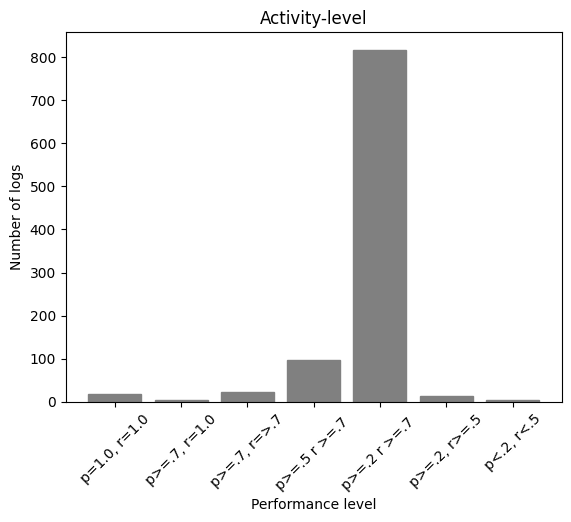

In [163]:
import matplotlib.pyplot as plt

# Sample data
categories = ['p=1.0, r=1.0','p>=.7, r=1.0', 'p>=.7, r=>.7', 'p>=.5 r >=.7 ', 'p>=.2 r >=.7 ', 'p>=.2, r>=.5', 'p<.2, r<.5']
values = [counts_perfect["Activity"], counts_great["Activity"], counts_good["Activity"], counts_medium_good["Activity"], counts_medium["Activity"], counts_medium_bad["Activity"], counts_bad["Activity"]]

# Creating the bar chart
bars = plt.bar(categories, values)
for bar in bars:
    bar.set_color('gray')

# Adding labels and title
plt.xlabel('Performance level')
plt.ylabel('Number of logs')
plt.title('Activity-level')
plt.xticks(rotation = 45)

# Displaying the chart
plt.show()

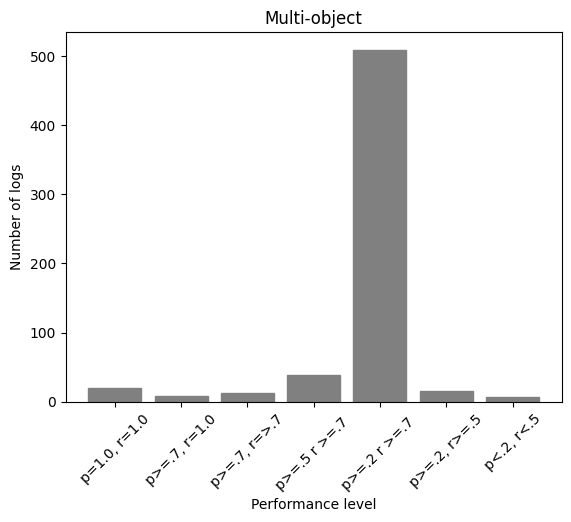

In [164]:
import matplotlib.pyplot as plt

# Sample data
categories = ['p=1.0, r=1.0','p>=.7, r=1.0', 'p>=.7, r=>.7', 'p>=.5 r >=.7 ', 'p>=.2 r >=.7 ', 'p>=.2, r>=.5', 'p<.2, r<.5']
values = [counts_perfect["Multi-object"], counts_great["Multi-object"], counts_good["Multi-object"], counts_medium_good["Multi-object"], counts_medium["Multi-object"], counts_medium_bad["Multi-object"], counts_bad["Multi-object"]]

# Creating the bar chart
bars = plt.bar(categories, values)
for bar in bars:
    bar.set_color('gray')

# Adding labels and title
plt.xlabel('Performance level')
plt.ylabel('Number of logs')
plt.title('Multi-object')
plt.xticks(rotation = 45)

# Displaying the chart
plt.show()

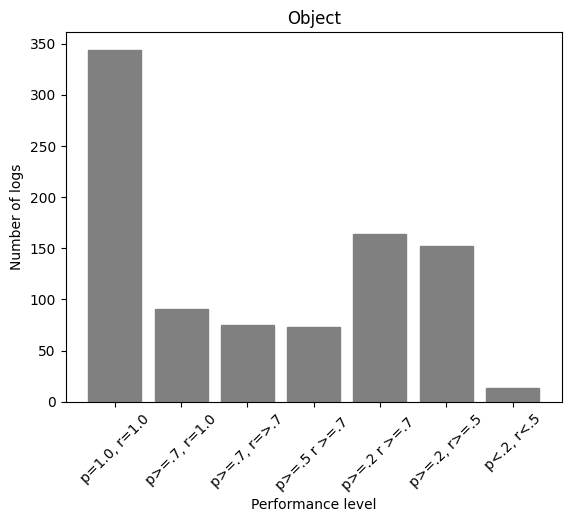

In [165]:
import matplotlib.pyplot as plt

# Sample data
categories = ['p=1.0, r=1.0','p>=.7, r=1.0', 'p>=.7, r=>.7', 'p>=.5 r >=.7 ', 'p>=.2 r >=.7 ', 'p>=.2, r>=.5', 'p<.2, r<.5']
values = [counts_perfect["Object"], counts_great["Object"], counts_good["Object"], counts_medium_good["Object"], counts_medium["Object"], counts_medium_bad["Object"], counts_bad["Object"]]

# Creating the bar chart
bars = plt.bar(categories, values)
for bar in bars:
    bar.set_color('gray')

# Adding labels and title
plt.xlabel('Performance level')
plt.ylabel('Number of logs')
plt.title('Object')
plt.xticks(rotation = 45)

# Displaying the chart
plt.show()

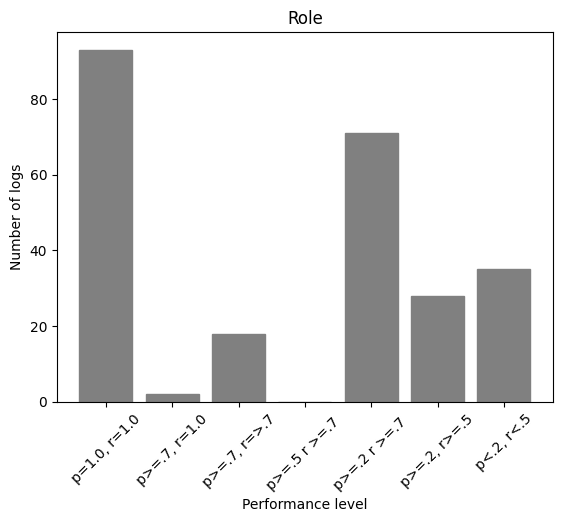

In [166]:
import matplotlib.pyplot as plt

# Sample data
categories = ['p=1.0, r=1.0','p>=.7, r=1.0', 'p>=.7, r=>.7', 'p>=.5 r >=.7 ', 'p>=.2 r >=.7 ', 'p>=.2, r>=.5', 'p<.2, r<.5']
values = [counts_perfect["Resource"], counts_great["Resource"], counts_good["Resource"], counts_medium_good["Resource"], counts_medium["Resource"], counts_medium_bad["Resource"], counts_bad["Resource"]]

# Creating the bar chart
bars = plt.bar(categories, values)
for bar in bars:
    bar.set_color('gray')

# Adding labels and title
plt.xlabel('Performance level')
plt.ylabel('Number of logs')
plt.title('Role')
plt.xticks(rotation = 45)

# Displaying the chart
plt.show()

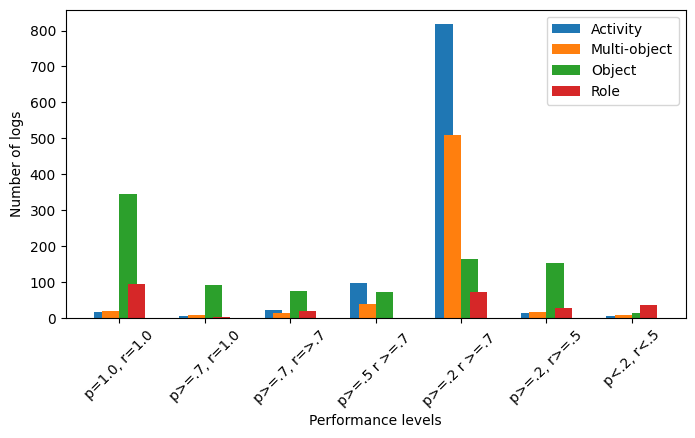

In [167]:
import numpy as np
import matplotlib.pyplot as plt

# Data for the bars
categories = ['p=1.0, r=1.0','p>=.7, r=1.0', 'p>=.7, r=>.7', 'p>=.5 r >=.7 ', 'p>=.2 r >=.7 ', 'p>=.2, r>=.5', 'p<.2, r<.5']
bar1_values = [counts_perfect["Activity"],counts_great["Activity"], counts_good["Activity"], counts_medium_good["Activity"], counts_medium["Activity"], counts_medium_bad["Activity"], counts_bad["Activity"]]
bar2_values = [counts_perfect["Multi-object"], counts_great["Multi-object"], counts_good["Multi-object"], counts_medium_good["Multi-object"], counts_medium["Multi-object"], counts_medium_bad["Multi-object"], counts_bad["Multi-object"]]
bar3_values = [counts_perfect["Object"], counts_great["Object"], counts_good["Object"], counts_medium_good["Object"], counts_medium["Object"], counts_medium_bad["Object"], counts_bad["Object"]]
bar4_values = [counts_perfect["Resource"], counts_great["Resource"], counts_good["Resource"], counts_medium_good["Resource"], counts_medium["Resource"], counts_medium_bad["Resource"], counts_bad["Resource"]]

# Position of bars on x-axis
x = np.arange(len(categories))

# Width of each bar
bar_width = 0.2

# Creating the grouped bar chart
fig, ax = plt.subplots(figsize=(8, 4))
bar1 = ax.bar(x - bar_width, bar1_values, bar_width, label='Activity')
bar2 = ax.bar(x - bar_width/2, bar2_values, bar_width, label='Multi-object')
bar3 = ax.bar(x + bar_width/2, bar3_values, bar_width, label='Object')
bar4 = ax.bar(x + bar_width, bar4_values, bar_width, label='Role')

# Adding labels, title, and ticks
ax.set_xlabel('Performance levels')
ax.set_ylabel('Number of logs')
#ax.set_title('Grouped Bar Chart')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
plt.xticks(rotation = 45)

# Display the chart
plt.show()

In [162]:
import os
from pathlib import Path
from semconstmining.config import Config
import pandas as pd
import time
conf = Config(Path(os.getcwd()).parents[1].resolve(), "sap_sam_filtered_2500")
log_dir = conf.DATA_EVAL / (conf.MODEL_COLLECTION + "_noisy.pkl")
logs = pd.read_pickle(log_dir)

cnt = 0
for idx, row in logs.iterrows():
    log = row[conf.LOG]
    noisy_log =  row[conf.NOISY_LOG]
    if len(row[conf.LOG]._list) <=1:
        print(row[conf.MODEL_ID])
        cnt += 1

print(cnt)

1be852b48fb24bfc8aab46caf7cf0928
1c0fdaf892db48759871b78bf54bba6b
1c2f94c5662b4537ad3e716a80ac89ca
1c45c69b93b347e29ff3dea0a731e1c1
1da20cfa717944168f0e47e975d87b76
1de94027e693495fb89d28cc22af81c8
1e00258995924821be2f772d889290d6
410aec05d68144be943693a9ebb7d0b8
411d652b049547dfa0a15dee30f0e440
6483491dd000442894c4a79d784590b4
64dfe71bbd8446c19fb48a468781fc01
6519a97275ed4d078e3a1091bce4fd15
65a18a6a4df04dc4bceac71e8563515e
65b1af0fb6c0464a82e48513afc1460c
660d830ba5ce4dfe9cc85e102fadfbf6
662c096587b14aef9990ca4b26739965
39d34b6f9d67499e9f5a72f52d53f412
3a1400c927a146479d5f90a5e8b0b4a2
3a184d0a00c448c6bd17636b7ce6dc71
3b56490e9fb6417b8a6d8c191e97ee74
3b78d4323e754b50b5d007168e0a5b66
3be368b0244a49f09126a57d618b2804
18cd0986b56849949617db8ea30db7b3
191131cd6be54ff2b14149f0b8fce4dd
19117310241d45b3bd465c8947e060a4
0a514af86aa5468f8955efc22e63c4da
0ae2d60656874fb2b5673507a81a1d38
0b2009450ac74f88a52ed06c9278cc00
0b375496f4bc4b5db10a3294ad018a94
0b5fe3e2c0d94df8b4e2f310d0938c03
0b681b2413

In [7]:
from statistics import mean
import pickle
import os
from pathlib import Path
from semconstmining.config import Config

import pandas as pd
conf = Config(Path(os.getcwd()).parents[1].resolve(), "sap_sam_filtered")
gold_standard_violations = pickle.load(open(conf.DATA_EVAL / 'gold_standard_violations.pkl', 'rb'))

violating_cases_per_log = {conf.ACTIVITY: [], conf.RESOURCE: [], conf.OBJECT: [], conf.MULTI_OBJECT: []}
violations_total_per_log = {conf.ACTIVITY: [], conf.RESOURCE: [], conf.OBJECT: [], conf.MULTI_OBJECT: []}

for log, log_violations in gold_standard_violations.items():
    for const_type, const_violations in log_violations.items():
        violation_cases = 0
        violation_total = 0
        if const_type == "Object":
            cases_seen = set()
            for obj_type, obj_violations in const_violations.items():
                for case, case_violations in obj_violations.items():
                    if len(case_violations)>0:
                        if not case in cases_seen:
                            violation_cases += 1
                            cases_seen.add(case)
                        violation_total += len(case_violations)
        else:
            for case, case_violations in const_violations.items():
                if len(case_violations)>0:
                    violation_cases += 1
                    violation_total += len(case_violations)

        violating_cases_per_log[const_type].append(violation_cases)
        violations_total_per_log[const_type].append(violation_total)

const_column = [conf.ACTIVITY, conf.MULTI_OBJECT, conf.OBJECT, conf.RESOURCE]
violating_cases_mean = [mean(violating_cases_per_log[const_type]) for const_type in const_column]
violating_total_mean = [mean(violations_total_per_log[const_type]) for const_type in const_column]
violating_cases_max = [max(violating_cases_per_log[const_type]) for const_type in const_column]
violating_total_max = [max(violations_total_per_log[const_type]) for const_type in const_column]


violations_df = pd.DataFrame({
    'Type': const_column,
    'Avg. violating cases': violating_cases_mean,
    'Max. violating cases': violating_cases_max,
    'Avg. total violations': violating_total_mean,
    'Max. total violations': violating_total_max,
})
violations_df

,Type,Avg. violating cases,Max. violating cases,Avg. total violations,Max. total violations
0,Activity,40.765574,312,168.999180,1979
1,Multi-object,28.343443,276,95.346721,1453
2,Object,38.312295,199,91.220492,905
3,Resource,9.136066,150,11.468852,172


In [175]:
violations_df.T

In [8]:
print(violations_df.to_latex(index_names=False, index=False, float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
Type & Avg. violating cases & Max. violating cases & Avg. total violations & Max. total violations \\
\midrule
Activity & 40.77 & 312 & 169.00 & 1979 \\
Multi-object & 28.34 & 276 & 95.35 & 1453 \\
Object & 38.31 & 199 & 91.22 & 905 \\
Resource & 9.14 & 150 & 11.47 & 172 \\
\bottomrule
\end{tabular}

